In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit import Parameter
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [3]:
df = pd.read_csv('Datasets/Mentor/mock_train_set.csv')
df.head(8)

,0,1,2,3,x
0,2789.26,1000,10,20,0
1,4040.01,1000000,1,1,1
2,2931.20,10000,10000,40,1
3,3896.54,10000,100000,30,1
4,982.06,100,1000,75,0
5,1579.81,1,1000,90,0
6,3031.77,1000000,1000000,35,1
7,860.44,10,100000,60,0


In [4]:
df_test = pd.read_csv('Datasets/Mentor/mock_test_set.csv')
df_test.head(8)

,0,1,2,3,x
0,2988.55,10000,10000,75,1
1,3413.80,1,100,90,0
2,3891.52,1,1,5,0
3,4514.99,10000,1000000,25,1
4,752.29,10,10,90,0
5,1404.13,10000,1000,5,1
6,3390.65,1000000,10000,5,1
7,2620.98,1,10,75,0


In [5]:
f_name_list = list(df)
list(f_name_list)

['0', '1', '2', '3', 'x']

In [6]:
print('Number of empty data in the set: '), df.isnull().sum().sum()
clean_data = df.dropna()

Number of empty data in the set: 


In [7]:
#clean_data = clean_data.drop('Unnamed: 0', axis=1)
x_org = clean_data.drop('x', axis=1)
cat = clean_data.x

rel = ExtraTreesClassifier()
rel.fit(x_org, cat)

ExtraTreesClassifier()

In [8]:
print(rel.feature_importances_)

[0.1337095  0.50337729 0.26299004 0.09992317]


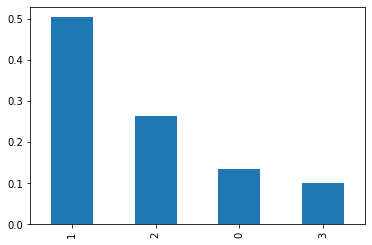

In [9]:
rank_f = pd.Series(rel.feature_importances_, index=x_org.columns)
rank_f.nlargest(20).plot(kind='bar')
plt.show()

In [10]:
corr = clean_data.iloc[:,:-1].corr()
classified = mutual_info_classif(x_org, cat)
class_data = pd.Series(classified, index=x_org.columns)
ordered_f = class_data.sort_values(ascending=False)

In [11]:
ordered_f.head(10)

1    0.330197
2    0.277446
0    0.060894
3    0.000000
dtype: float64

In [12]:
test_ratio = 0.2
seed = 1984
selected_f = clean_data[['0','1','2','3','x']]
selected_test = df_test[['0','1','2','3','x']]

x_train = np.array(selected_f.drop('x', axis =1))
y_train = np.array(selected_f.x)
x = preprocessing.normalize(x_train, axis=0)

x_test = np.array(selected_test.drop('x', axis =1))
y_test = np.array(selected_test.x)
x = preprocessing.normalize(x_test, axis=0)

#x_train, x_test, y_train, y_test = train_test_split(x, cat, test_size=test_ratio, random_state=seed, stratify=cat)

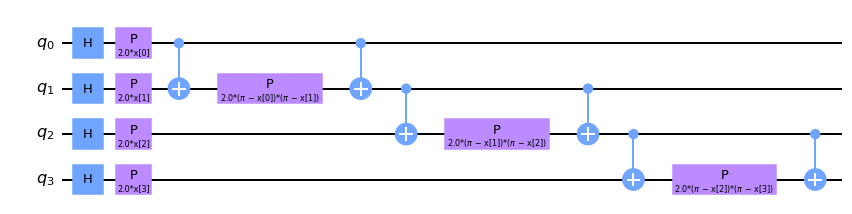

In [13]:
feature_dim = x.shape[1]
emb_layer = 1
ent = 'linear'

fmap = ZZFeatureMap(feature_dimension=feature_dim, reps=emb_layer, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

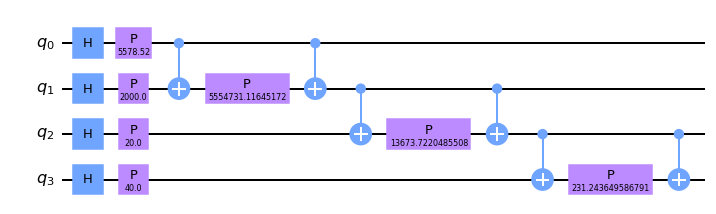

In [14]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

In [15]:
def ansatz_circ(feature_dim, layer, weights):
    ansatz = QuantumCircuit(feature_dim)
    for layer in range(layer):
        for i in range(feature_dim):
            ansatz.ry(weights[i], i)
            ansatz.rz(weights[i+4], i)
        for i in range(feature_dim - 1):
            ansatz.cx(i, i+1)
        ansatz.cx(3,0)
        ansatz.barrier()
    return ansatz

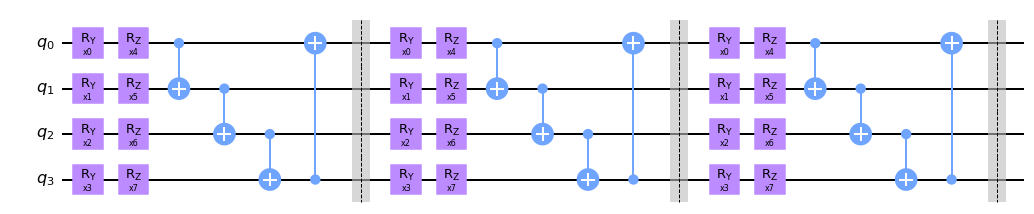

In [16]:
layer = 3
np.random.seed(seed)
nb_w = 8
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

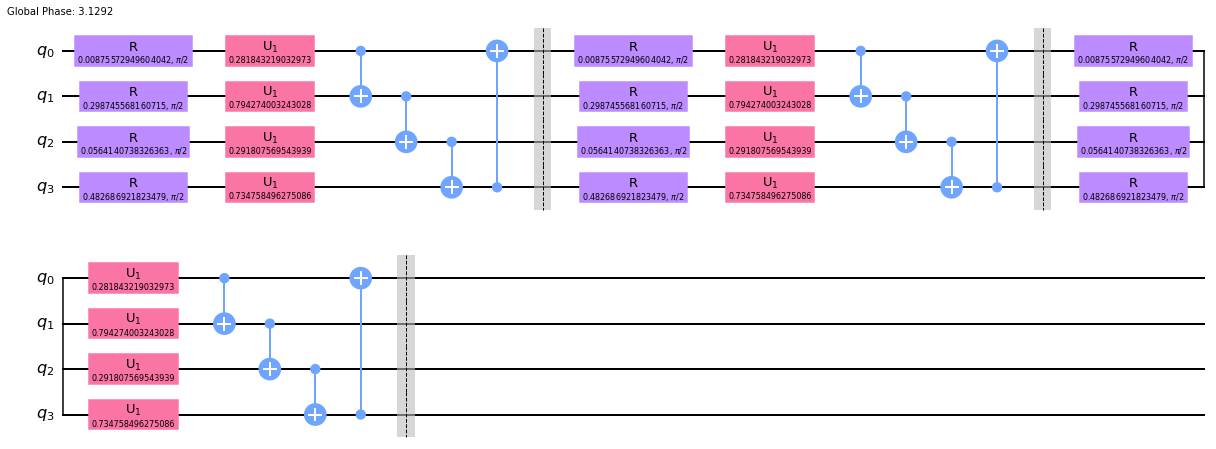

In [17]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

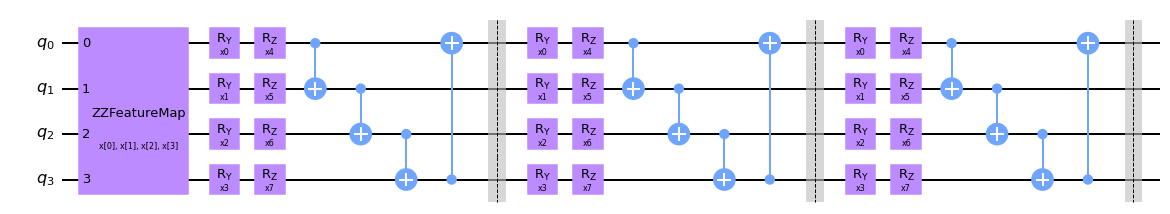

In [18]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [19]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [20]:
qasm_sim = Aer.get_backend('aer_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [21]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [22]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.54785156, 0.45214844]])

In [23]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.06689453,  0.06884766,  0.41943359, -0.05786133,
          0.05419922,  0.1105957 , -0.03125   , -0.08032227],
        [-0.06689453, -0.06884766, -0.41943359,  0.05786133,
         -0.05419922, -0.1105957 ,  0.03125   ,  0.08032227]]])

In [24]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [25]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [26]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 316.317121368119
6 - 305.71999649848203
9 - 301.2765252595571
12 - 301.3346626681705
15 - 302.3958397574546
18 - 299.3209498778276
21 - 299.83080302263556
24 - 298.83058416247474
27 - 299.0650478006094
30 - 298.4079130766629
33 - 296.7351487077474
36 - 295.7317287675552
39 - 295.51882824094287
42 - 295.8023341735433
45 - 295.7928005993046
48 - 295.68696272883994
51 - 295.63366629213493
54 - 295.79445358865325
57 - 294.89401087460965
60 - 294.95305395363357
63 - 294.70206083804436
66 - 294.51521672748686
69 - 294.6323830808915
72 - 293.8272725622425
75 - 294.6569117155162
78 - 293.71647418365336
81 - 293.61873716358986
84 - 293.41710393999335
87 - 293.44366982205065
90 - 292.910785630856
93 - 293.0822238596541
96 - 292.8263013146319
99 - 293.12556216669253
102 - 293.59349391321075
105 - 293.1850566432089
108 - 293.0300423780742
111 - 293.063279789131
114 - 293.16789826794144
117 - 293.21066643500217
120 - 292.9990670296022
123 - 292.9639616954646
126 - 293.43996785487445
129 - 293.4

In [27]:
score_train_1 = vqc.score(x_train, y_train_1h)
score_test_1 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_1}')
print(f'Score on the test set {score_test_1}')

Score on the train set 0.59
Score on the test set 0.49166666666666664


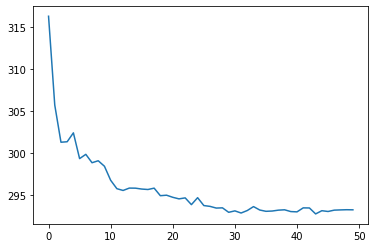

In [28]:
plt.plot(loss_recorder)

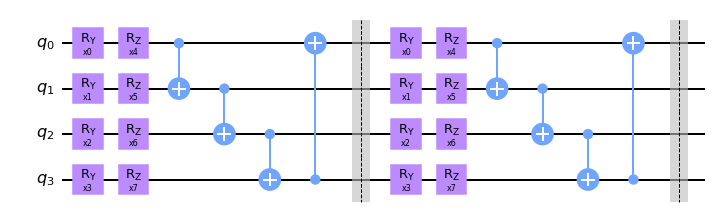

In [29]:
layer = 2
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

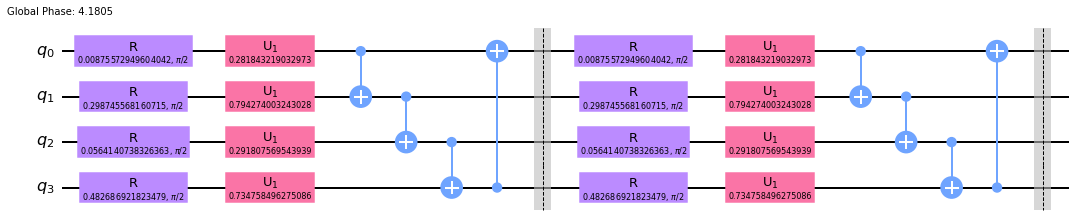

In [30]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

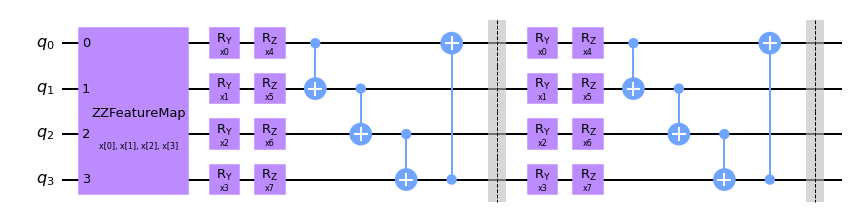

In [31]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [32]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [33]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.59863281, 0.40136719]])

In [34]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.00073242,  0.28881836, -0.00219727, -0.11694336,
         -0.03076172,  0.10058594,  0.04052734, -0.03149414],
        [-0.00073242, -0.28881836,  0.00219727,  0.11694336,
          0.03076172, -0.10058594, -0.04052734,  0.03149414]]])

In [35]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 300.7024558306747
6 - 300.64047894365945
9 - 300.7415815273948
12 - 300.91074837736414
15 - 300.40935837135356
18 - 304.57903364624747
21 - 303.8535716508538
24 - 308.10297199243803
27 - 304.22149797651446
30 - 305.29128736767103
33 - 304.5156862705079
36 - 301.24562619594593
39 - 301.0423481839391
42 - 301.2859071637371
45 - 300.1717166105499
48 - 300.10244942287164
51 - 300.4166309488954
54 - 300.177330084721
57 - 299.7593652842211
60 - 299.2354079358193
63 - 298.9741166815314
66 - 299.23808990460094
69 - 299.27912843161687
72 - 298.6494140754853
75 - 296.8286779417956
78 - 296.75670290337047
81 - 296.13298801383223
84 - 295.8022472413753
87 - 294.1521914197045
90 - 293.83203561106643
93 - 294.0325828361455
96 - 293.0979117040954
99 - 293.1545734937682
102 - 293.12082147343176
105 - 293.0940032618657
108 - 292.93582318010397
111 - 292.9340936782942
114 - 292.35779990415404
117 - 292.2739368621451
120 - 291.87230837784557
123 - 292.25907900190333
126 - 291.99084910096565
129 - 292

In [36]:
score_train_2 = vqc.score(x_train, y_train_1h)
score_test_2 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_2}')
print(f'Score on the test set {score_test_2}')

Score on the train set 0.57
Score on the test set 0.575


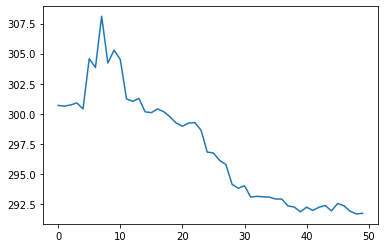

In [37]:
plt.plot(loss_recorder)

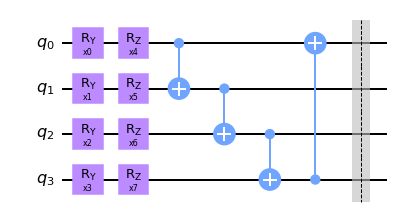

In [38]:
layer = 1
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

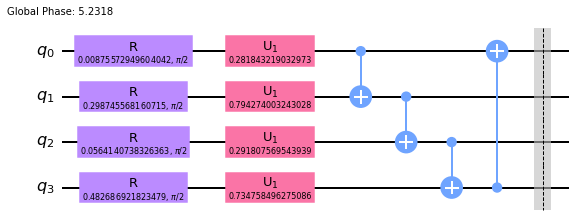

In [39]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

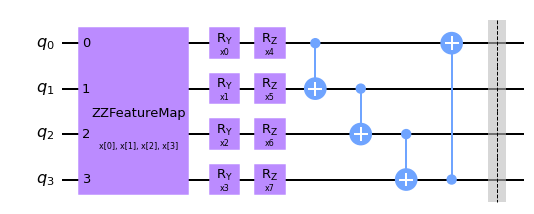

In [40]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [41]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [42]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.50341797, 0.49658203]])

In [43]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.00219727,  0.02929687, -0.06469727,  0.03979492,
          0.0078125 , -0.01708984, -0.00366211,  0.00244141],
        [-0.00219727, -0.02929687,  0.06469727, -0.03979492,
         -0.0078125 ,  0.01708984,  0.00366211, -0.00244141]]])

In [44]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 299.46836024192623
6 - 299.02037758806875
9 - 298.8173421677239
12 - 298.7772918414198
15 - 298.7760712723764
18 - 298.7058329585623
21 - 297.84988772678923
24 - 297.21955954385646
27 - 297.20169246869744
30 - 297.1951939263221
33 - 297.1516623952172
36 - 297.157017138579
39 - 297.0730954420004
42 - 297.4216453720106
45 - 296.8816680947048
48 - 297.0593545518785
51 - 297.1219131629275
54 - 296.87817497340666
57 - 296.6724527045185
60 - 296.6584184684144
63 - 295.71223885580673
66 - 295.9081373312971
69 - 295.7857703295261
72 - 295.62118050846914
75 - 295.57576084937824
78 - 295.6438303913463
81 - 295.2578714468193
84 - 295.25896423465815
87 - 295.62654903879206
90 - 295.35322347738145
93 - 295.0967926104021
96 - 295.19886719489386
99 - 295.0711564997853
102 - 295.2054715662341
105 - 295.2972854904632
108 - 295.2186443491846
111 - 295.239428779346
114 - 295.3541053209591
117 - 295.4608375248676
120 - 295.399854237074
123 - 295.5434063419025
126 - 295.4064644538476
129 - 295.45528108

In [45]:
score_train_3 = vqc.score(x_train, y_train_1h)
score_test_3 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_3}')
print(f'Score on the test set {score_test_3}')

Score on the train set 0.56
Score on the test set 0.49166666666666664


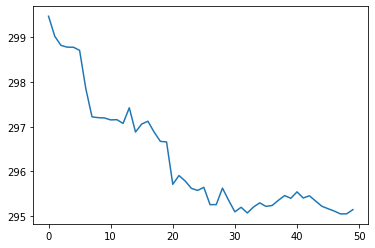

In [46]:
plt.plot(loss_recorder)